In [16]:
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import os
os.environ['LOKY_MAX_CPU_COUNT'] = str(os.cpu_count())  
import os
os.environ['OMP_NUM_THREADS'] = '1'  

In [18]:
train = pd.read_csv("C:\\Users\\sasar\\Desktop\\BSC\\CI\\train (1).csv")
test = pd.read_csv("C:\\Users\\sasar\\Desktop\\BSC\\CI\\test (1).csv")
sample_submission = pd.read_csv("C:\\Users\\sasar\\Desktop\\BSC\\CI\\sample_submission (1).csv")

In [19]:
print("Train Data Shape:", train.shape)
print("Test Data Shape:", test.shape)

Train Data Shape: (630000, 13)
Test Data Shape: (270000, 12)


In [20]:
train.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


In [21]:
test.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,high,easy
1,630001,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,low,easy
2,630002,24,female,b.tech,6.60,98.5,yes,6.2,good,group study,medium,moderate
3,630003,24,male,diploma,3.03,66.3,yes,5.7,average,mixed,medium,moderate
4,630004,20,female,b.tech,2.03,42.4,yes,9.2,average,coaching,low,moderate


In [22]:
print("\nMissing Values in Train:")
print(train.isnull().sum())
print("\nMissing Values in Test:")
print(test.isnull().sum())


Missing Values in Train:
id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64

Missing Values in Test:
id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
dtype: int64


In [23]:
train.describe()

,id,age,study_hours,class_attendance,sleep_hours,exam_score
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,314999.500000,20.545821,4.002337,71.987261,7.072758,62.506672
std,181865.479132,2.260238,2.359880,17.430098,1.744811,18.916884
min,0.000000,17.000000,0.080000,40.600000,4.100000,19.599000
25%,157499.750000,19.000000,1.970000,57.000000,5.600000,48.800000
50%,314999.500000,21.000000,4.000000,72.600000,7.100000,62.600000
75%,472499.250000,23.000000,6.050000,87.200000,8.600000,76.300000
max,629999.000000,24.000000,7.910000,99.400000,9.900000,100.000000


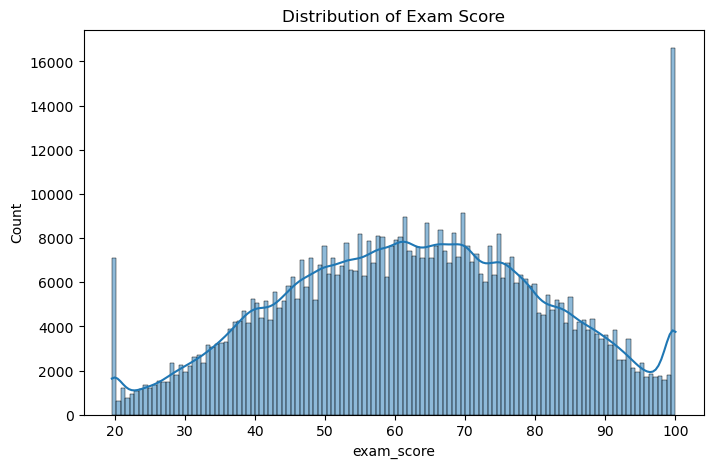

In [24]:
plt.figure(figsize=(8, 5))
sns.histplot(train['exam_score'], kde=True)
plt.title('Distribution of Exam Score')
plt.show()

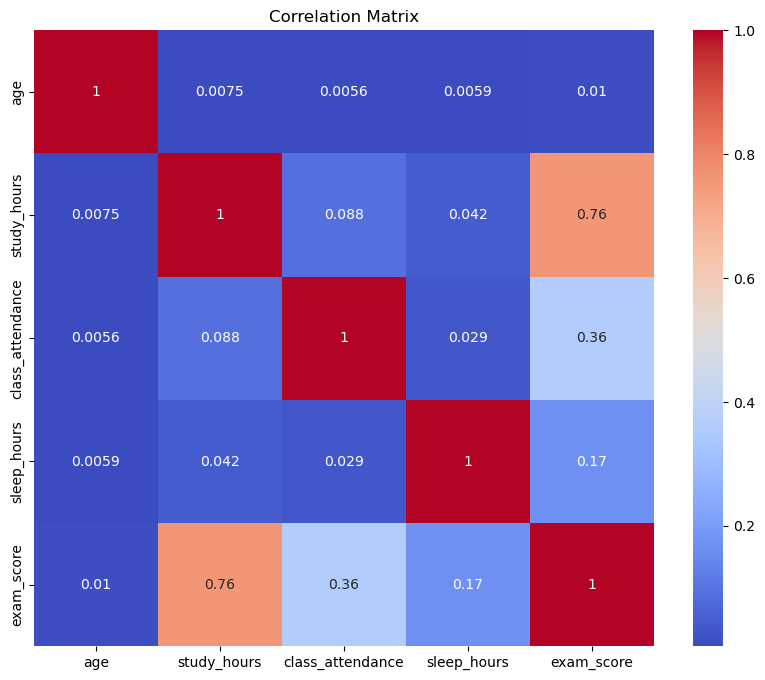

In [25]:
numerical_features = ['age', 'study_hours', 'class_attendance', 'sleep_hours']
corr_matrix = train[numerical_features + ['exam_score']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

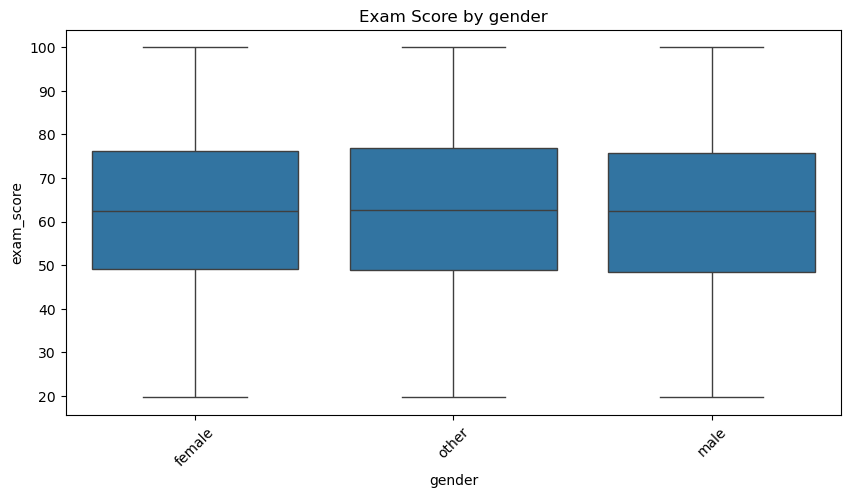

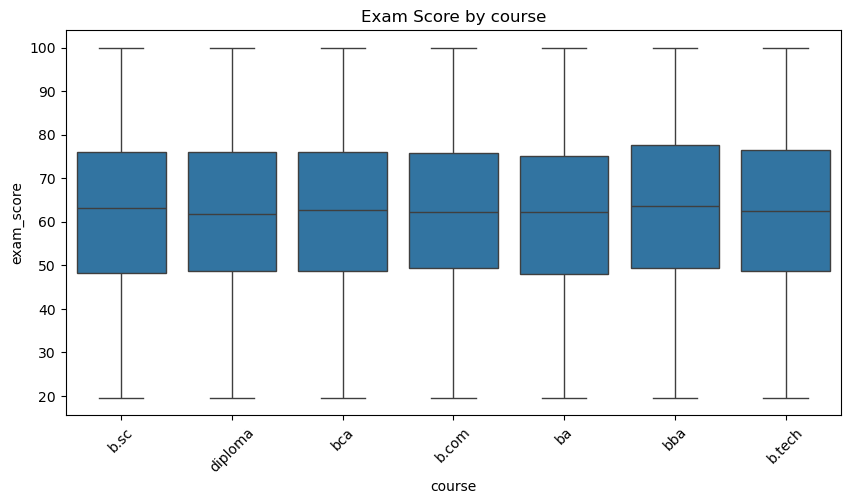

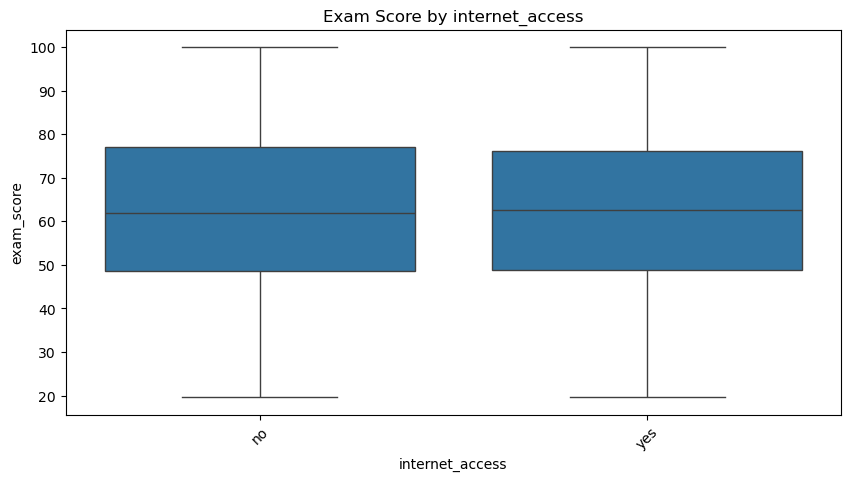

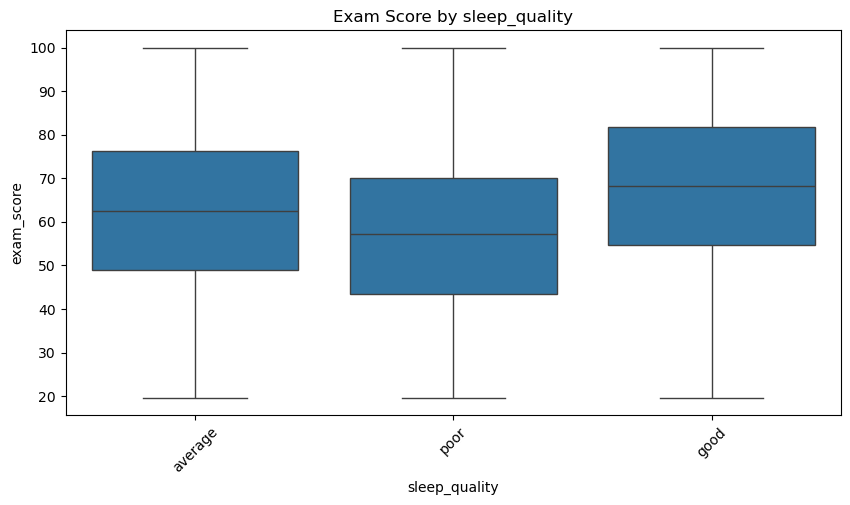

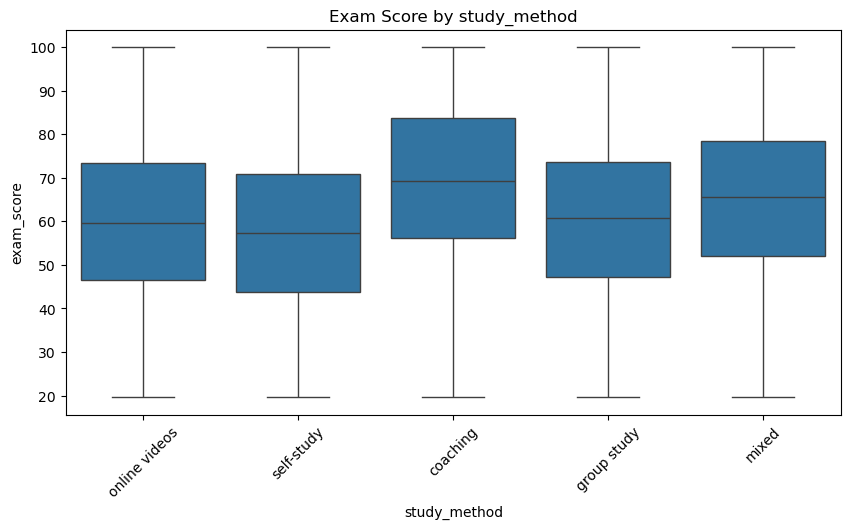

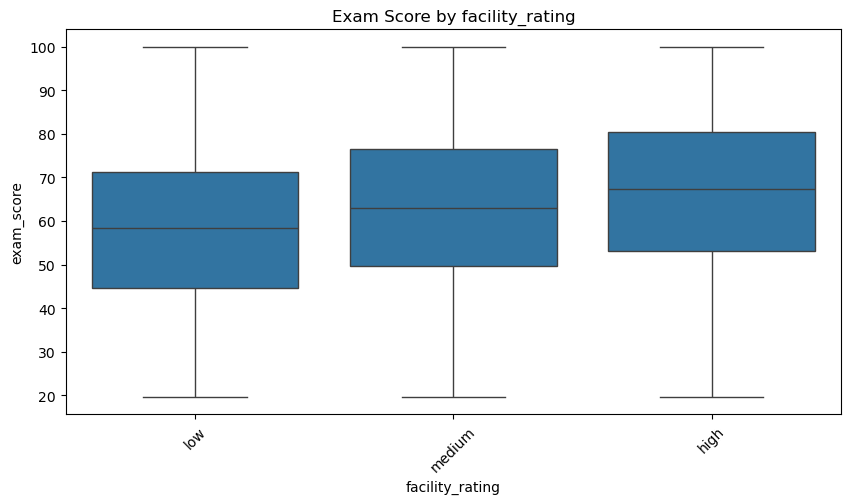

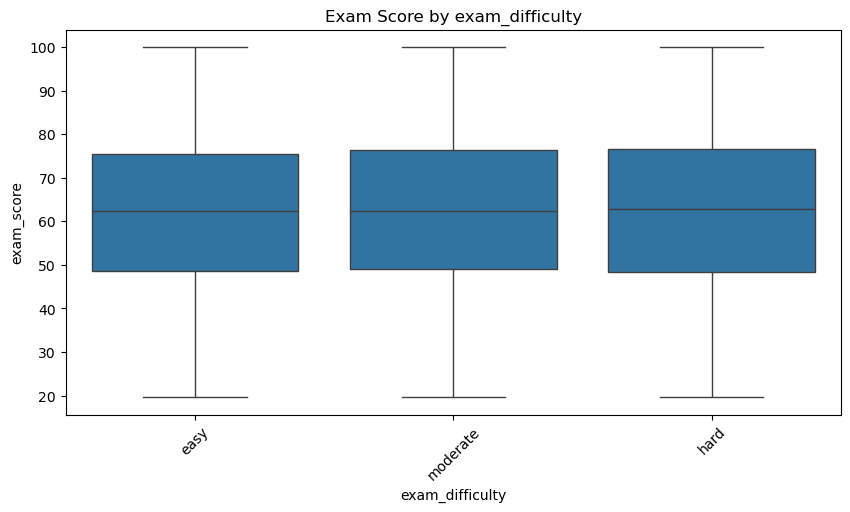

In [26]:
categorical_features = ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']
for cat in categorical_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=cat, y='exam_score', data=train)
    plt.title(f'Exam Score by {cat}')
    plt.xticks(rotation=45)
    plt.show()


Outliers in age: 0 (0.00%)
Lower Bound: 13.00, Upper Bound: 29.00

Outliers in study_hours: 0 (0.00%)
Lower Bound: -4.15, Upper Bound: 12.17

Outliers in class_attendance: 0 (0.00%)
Lower Bound: 11.70, Upper Bound: 132.50

Outliers in sleep_hours: 0 (0.00%)
Lower Bound: 1.10, Upper Bound: 13.10


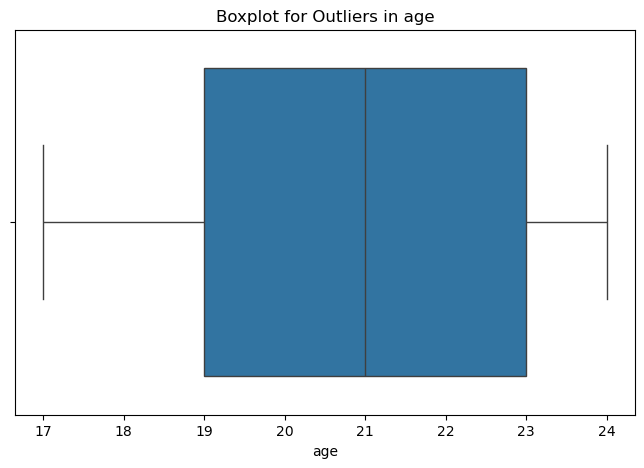

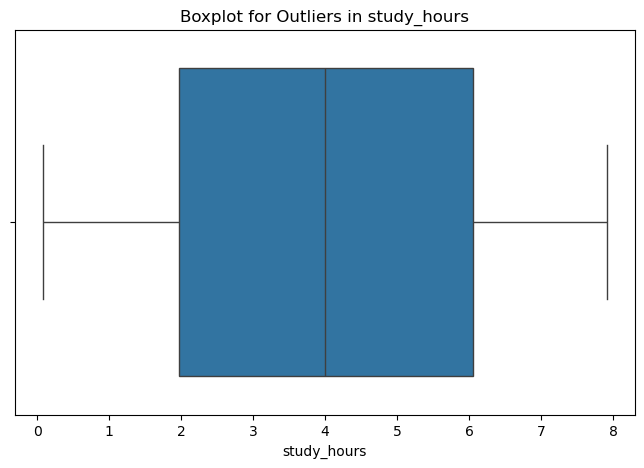

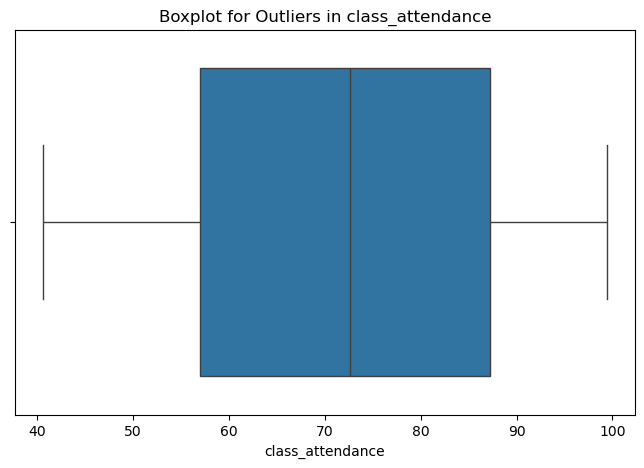

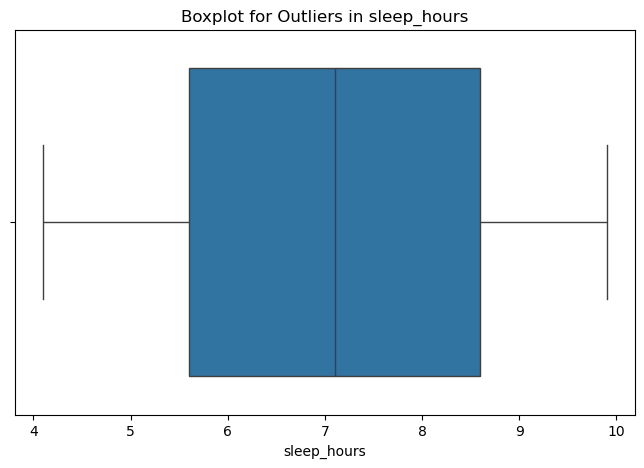

In [33]:
def detect_outliers_iqr(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    return outliers, lower_bound, upper_bound

for feature in numerical_features:
    outliers, lb, ub = detect_outliers_iqr(train, feature)
    print(f"\nOutliers in {feature}: {len(outliers)} ({len(outliers)/len(train)*100:.2f}%)")
    print(f"Lower Bound: {lb:.2f}, Upper Bound: {ub:.2f}")
    if not outliers.empty:
        print(outliers[[feature, 'exam_score']].head())  # Sample of outliers with target

for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=train[feature])
    plt.title(f'Boxplot for Outliers in {feature}')
    plt.show()




Distribution in gender:
gender
other     33.51
male      33.43
female    33.07
Name: proportion, dtype: float64


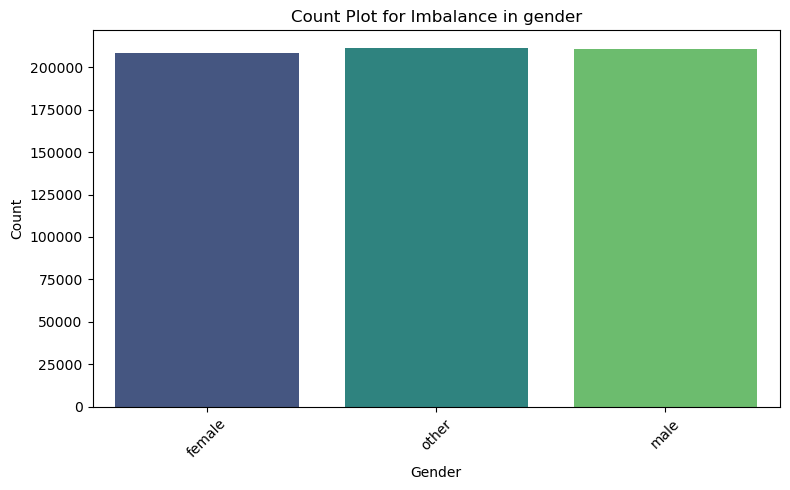


Distribution in course:
course
b.tech     20.83
b.sc       17.71
b.com      17.61
bca        14.08
bba        12.01
ba          9.84
diploma     7.92
Name: proportion, dtype: float64


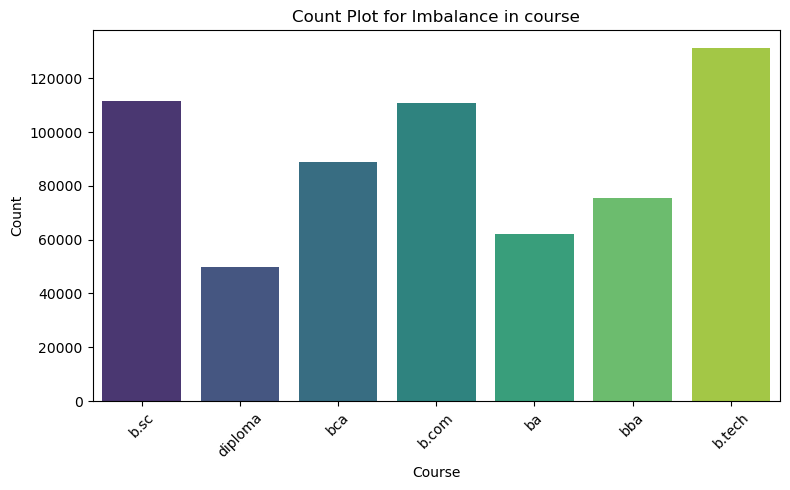


Distribution in internet_access:
internet_access
yes    91.97
no      8.03
Name: proportion, dtype: float64


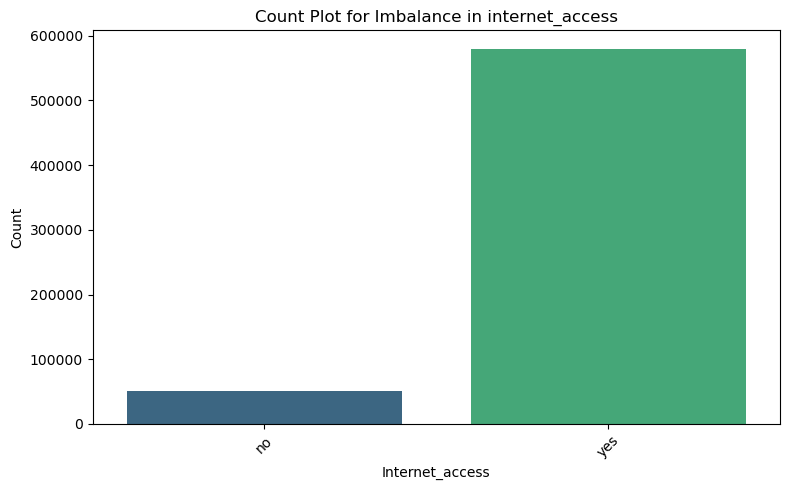


Distribution in sleep_quality:
sleep_quality
poor       33.92
good       33.82
average    32.26
Name: proportion, dtype: float64


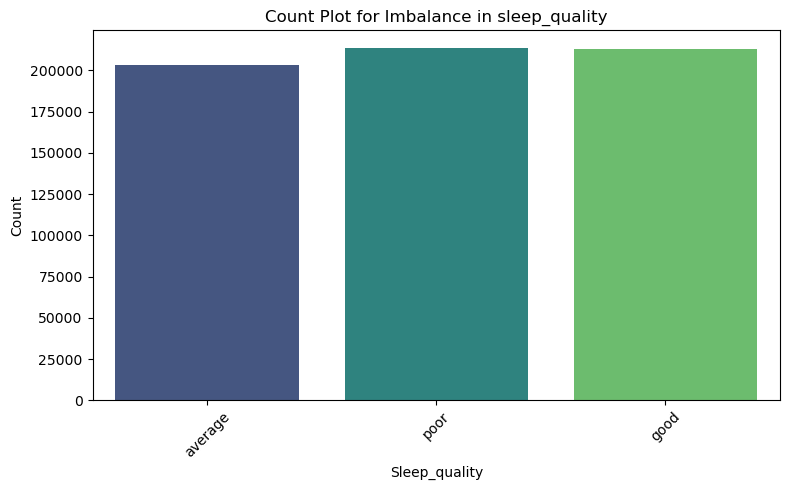


Distribution in study_method:
study_method
coaching         20.90
self-study       20.81
mixed            19.54
group study      19.53
online videos    19.22
Name: proportion, dtype: float64


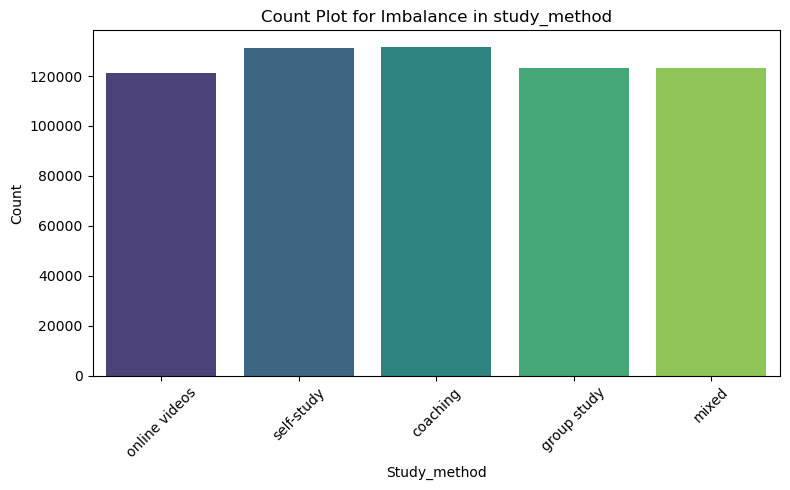


Distribution in facility_rating:
facility_rating
medium    33.98
low       33.71
high      32.31
Name: proportion, dtype: float64


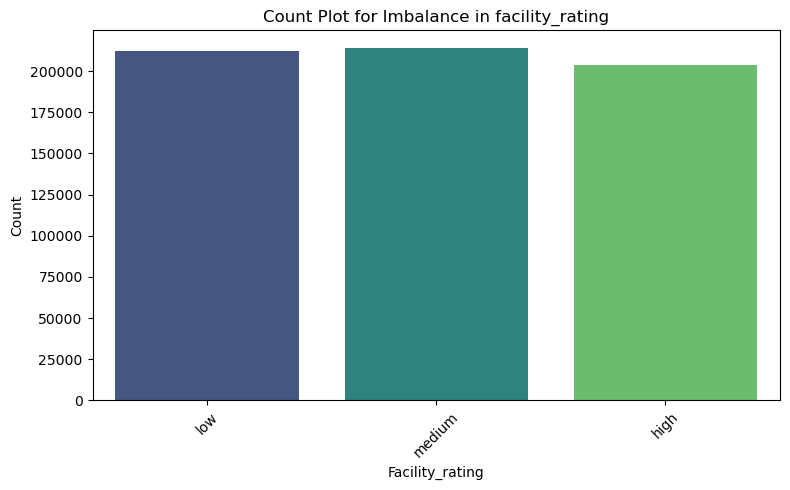


Distribution in exam_difficulty:
exam_difficulty
moderate    56.19
easy        28.02
hard        15.79
Name: proportion, dtype: float64


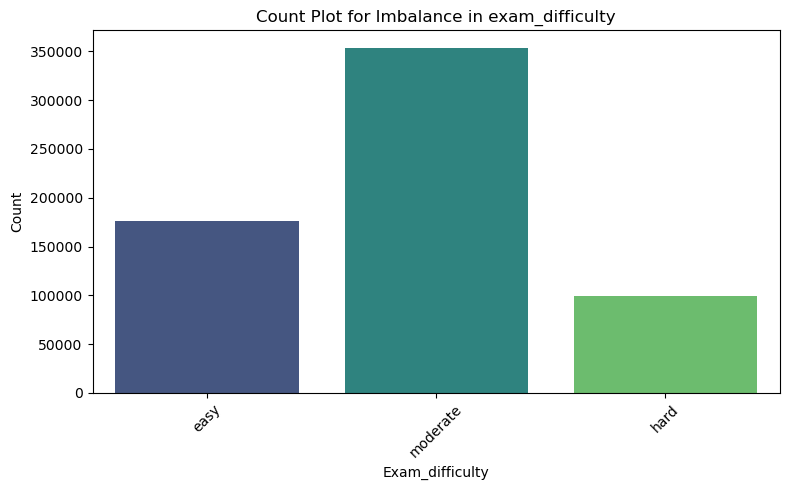

In [34]:
for feature in categorical_features:
    counts = train[feature].value_counts(normalize=True) * 100
    print(f"\nDistribution in {feature}:")
    print(counts.round(2))
    
   
    plt.figure(figsize=(8, 5))
    sns.countplot(
        x=train[feature],
        hue=train[feature],          
        palette='viridis',
        legend=False                 
    )
    plt.title(f'Count Plot for Imbalance in {feature}')
    plt.xticks(rotation=45)
    plt.xlabel(feature.capitalize())
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

In [11]:
X = train.drop(['id', 'exam_score'], axis=1)
y = train['exam_score']
X_test = test.drop(['id'], axis=1)

In [12]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [14]:
X_preprocessed = preprocessor.fit_transform(X)
X_test_preprocessed = preprocessor.transform(X_test)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [16]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model_rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

model_rf.fit(X_train, y_train)
y_pred_val = model_rf.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print("\nRandom Forest Performance on Validation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

y_pred_test = model_rf.predict(X_test_preprocessed)

submission = pd.DataFrame({
    'id': test['id'],
    'exam_score': y_pred_test
})

submission.to_csv('submission_random_forest.csv', index=False)
print("\nFile created: submission_random_forest.csv")


Random Forest Performance on Validation:
RMSE: 9.0892
MAE: 7.2334
R²: 0.7677

File created: submission_random_forest.csv


In [18]:
from sklearn.ensemble import GradientBoostingRegressor
model_gb = GradientBoostingRegressor(
    n_estimators=100,
    random_state=42
)
model_gb.fit(X_train, y_train)
y_pred_val = model_gb.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
print("\nGradient Boosting Performance on Validation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

submission.to_csv('submission_GradientBoostingRegressor.csv', index=False)
print("\nFile created: submission_GradientBoostingRegressor.csv")


Gradient Boosting Performance on Validation:
RMSE: 8.8407
MAE: 7.0654
R²: 0.7802

File created: submission_GradientBoostingRegressor.csv


In [19]:
model_xgb = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    random_state=42
)
model_xgb.fit(X_train, y_train)
y_pred_val = model_xgb.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
print("\nXGBoost Performance on Validation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

submission.to_csv('submission_XGBoost.csv', index=False)
print("\nFile created: submission_XGBoost.csv")


XGBoost Performance on Validation:
RMSE: 8.8243
MAE: 7.0534
R²: 0.7811

File created: submission_XGBoost.csv


Epoch 1/50
15750/15750 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 114.5135 - root_mean_squared_error: 10.7011 - val_loss: 181.4159 - val_root_mean_squared_error: 13.4691
Epoch 2/50
15750/15750 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - loss: 87.2321 - root_mean_squared_error: 9.3398 - val_loss: 123.8469 - val_root_mean_squared_error: 11.1287
Epoch 3/50
15750/15750 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - loss: 84.1511 - root_mean_squared_error: 9.1734 - val_loss: 122.5298 - val_root_mean_squared_error: 11.0693
Epoch 4/50
15750/15750 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step - loss: 82.7592 - root_mean_squared_error: 9.0972 - val_loss: 106.9143 - val_root_mean_squared_error: 10.3399
Epoch 5/50
15750/15750 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 81.9635 - root_mean_squared_error: 9.0534 - val_loss: 100.0653 - val_root_mean_squared_error: 10.0033
Epoch 6/50
15750/15750 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 81.3858 - root_mean_squared_error: 9.0214 - val_loss: 90.7766 - val_root_mean_squared_error: 9.527

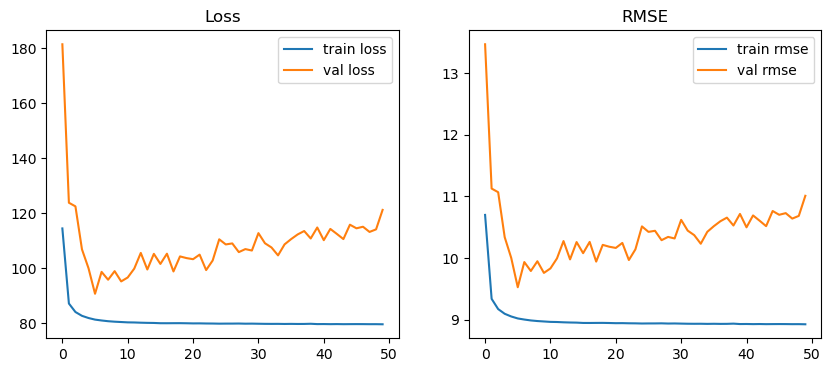

3938/3938 ━━━━━━━━━━━━━━━━━━━━ 3s 841us/step

Neural Network Performance on Validation:
RMSE: 11.0111
MAE: 8.8472
R²: 0.6591

File created: submission_Nural_network.csv


In [20]:
from tensorflow.keras import layers  
model_nn = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model_nn.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['root_mean_squared_error']
)
history = model_nn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['root_mean_squared_error'], label='train rmse')
plt.plot(history.history['val_root_mean_squared_error'], label='val rmse')
plt.title('RMSE')
plt.legend()
plt.show()
y_pred_val = model_nn.predict(X_val).flatten()
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
print("\nNeural Network Performance on Validation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

submission.to_csv('submission_Nural_network.csv', index=False)
print("\nFile created: submission_Nural_network.csv")

In [22]:
model_cb = CatBoostRegressor(
    iterations=100,
    learning_rate=0.05,
    random_state=42,
    verbose=0  
)
model_cb.fit(X_train, y_train)
y_pred_val = model_cb.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
print("\nCatBoost Performance on Validation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

submission.to_csv('submission_CatBoost.csv', index=False)
print("\nFile created: submission_CatBoost.csv")


CatBoost Performance on Validation:
RMSE: 8.8734
MAE: 7.1016
R²: 0.7786

File created: submission_CatBoost.csv


In [23]:
import lightgbm as lgb  

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 100,
    'learning_rate': 0.05,
    'random_state': 42,
    'verbosity': -1
}

model_lgbm = lgb.train(
    params,
    train_data,
    valid_sets=[val_data]
)

y_pred_val = model_lgbm.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
print("\nLightGBM Performance on Validation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

importances = model_lgbm.feature_importance(importance_type='gain')  
y_pred_test = model_lgbm.predict(X_test_preprocessed)

submission.to_csv('submission_LightGBM.csv', index=False)
print("\nFile created: submission_LightGBM.csv")


LightGBM Performance on Validation:
RMSE: 8.8379
MAE: 7.0702
R²: 0.7804

File created: submission_LightGBM.csv


In [24]:
joblib.dump(model_xgb, 'xgboost_model.joblib')
print("Saved: xgboost_model.joblib")

joblib.dump(preprocessor, 'preprocessor.joblib')
print("Saved: preprocessor.joblib")

Saved: xgboost_model.joblib
Saved: preprocessor.joblib


Evaluating Neural Network...
3938/3938 ━━━━━━━━━━━━━━━━━━━━ 3s 745us/step

=== Neural Network ===
RMSE: 10.2815
MAE: 8.2472
R²: 0.7028


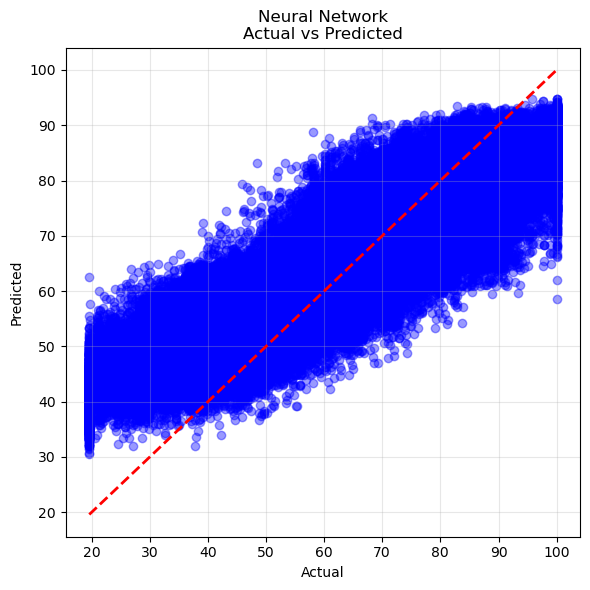


Evaluating Random Forest...

=== Random Forest ===
RMSE: 9.0892
MAE: 7.2334
R²: 0.7677


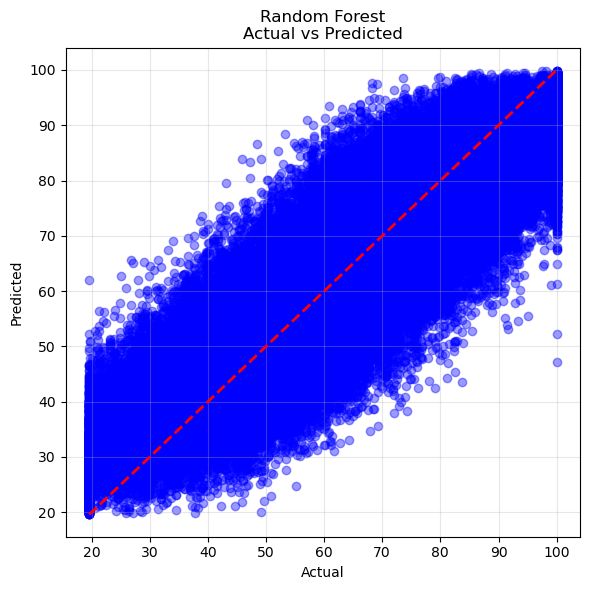


Evaluating Gradient Boosting...

=== Gradient Boosting ===
RMSE: 8.8407
MAE: 7.0654
R²: 0.7802


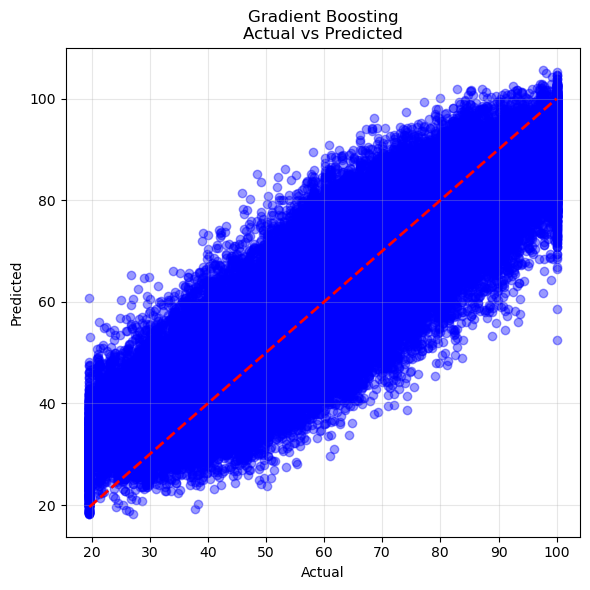


Evaluating XGBoost...

=== XGBoost ===
RMSE: 8.8243
MAE: 7.0534
R²: 0.7811


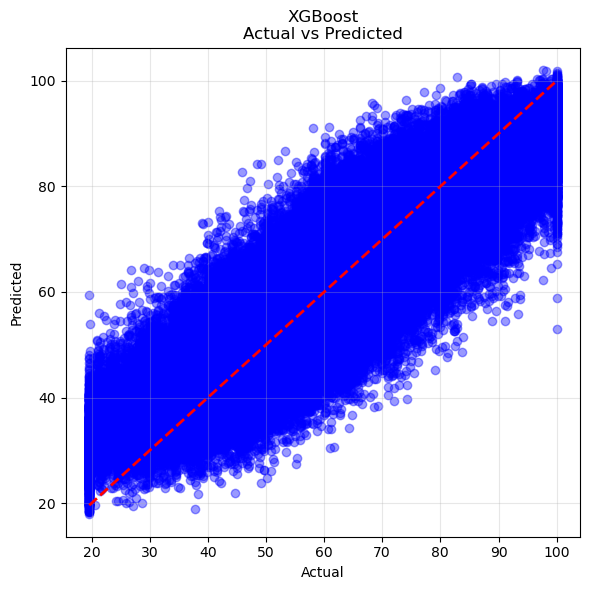


Evaluating LightGBM...

=== LightGBM ===
RMSE: 8.8379
MAE: 7.0702
R²: 0.7804


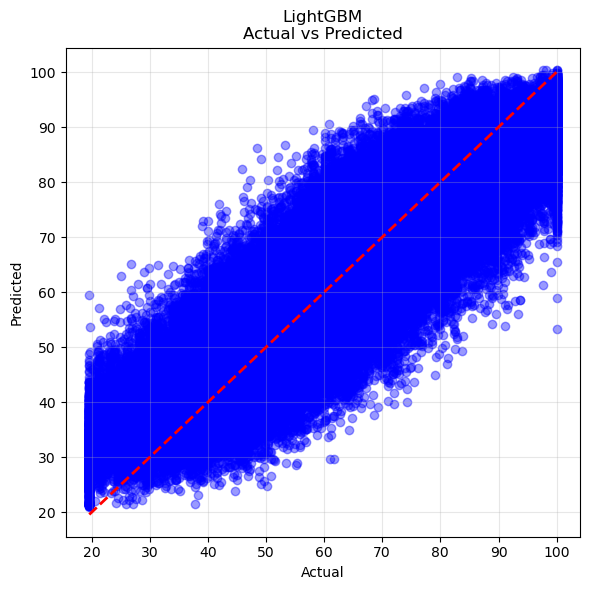


Evaluating CatBoost...

=== CatBoost ===
RMSE: 8.8734
MAE: 7.1016
R²: 0.7786


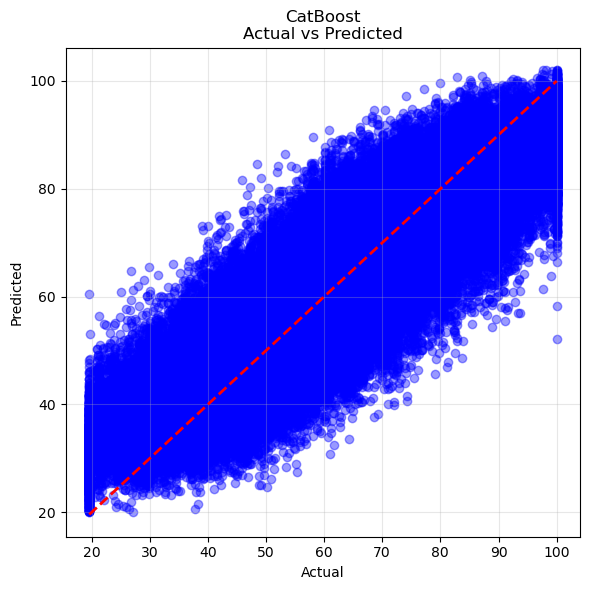

In [23]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
   
    print(f"\n=== {model_name} ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
   
  
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.4, color='blue')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
             'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{model_name}\nActual vs Predicted')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
   
    return rmse, mae, r2

print("Evaluating Neural Network...")
y_pred_nn = model_nn.predict(X_val).flatten()
rmse_nn, mae_nn, r2_nn = evaluate_model(y_val, y_pred_nn, "Neural Network")

print("\nEvaluating Random Forest...")
y_pred_rf = model_rf.predict(X_val)
rmse_rf, mae_rf, r2_rf = evaluate_model(y_val, y_pred_rf, "Random Forest")

print("\nEvaluating Gradient Boosting...")
y_pred_gb = model_gb.predict(X_val)
rmse_gb, mae_gb, r2_gb = evaluate_model(y_val, y_pred_gb, "Gradient Boosting")

print("\nEvaluating XGBoost...")
y_pred_xgb = model_xgb.predict(X_val)
rmse_xgb, mae_xgb, r2_xgb = evaluate_model(y_val, y_pred_xgb, "XGBoost")

print("\nEvaluating LightGBM...")
y_pred_lgbm = model_lgbm.predict(X_val)
rmse_lgbm, mae_lgbm, r2_lgbm = evaluate_model(y_val, y_pred_lgbm, "LightGBM")

print("\nEvaluating CatBoost...")
y_pred_cb = model_cb.predict(X_val)
rmse_cb, mae_cb, r2_cb = evaluate_model(y_val, y_pred_cb, "CatBoost")

In [26]:
models = {}
if 'rmse_rf' in globals(): models['Random Forest'] = rmse_rf
if 'rmse_gb' in globals(): models['Gradient Boosting'] = rmse_gb
if 'rmse_xgb' in globals(): models['XGBoost'] = rmse_xgb
if 'rmse_nn' in globals(): models['Neural Network'] = rmse_nn
if 'rmse_lgbm' in globals(): models['LightGBM'] = rmse_lgbm
if 'rmse_cb' in globals(): models['CatBoost'] = rmse_cb
if models:
    best_model = min(models, key=models.get)
    print(f"Best Model: {best_model} with RMSE: {models[best_model]:.4f}")
    print("\nAll RMSEs:")
    for m, r in models.items():
        print(f" {m:20} : {r:.4f}")
else:
    print("No RMSE variables found yet. Run the model notebooks first.")

Best Model: XGBoost with RMSE: 8.8243

All RMSEs:
 Random Forest        : 9.0892
 Gradient Boosting    : 8.8407
 XGBoost              : 8.8243
 Neural Network       : 10.2815
 LightGBM             : 8.8379
 CatBoost             : 8.8734


In [25]:
submission.to_csv(f'submission_{best_model.lower().replace(" ", "_")}.csv', index=False)
print(f"File created: submission_{best_model.lower().replace(' ', '_')}.csv")

File created: submission_xgboost.csv
